Load necessary modules to environment

In [5]:
import pandas as pd
import pyodbc
import numpy as np
from sqlalchemy import create_engine
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import machine_learning_new as ml
import matplotlib.pyplot as plt

In [6]:
conn_str = (
    r'DRIVER={SQL Server};'
    r'SERVER=lct-sqlbidev\dev;'
    r'DATABASE=Informatics_SSAS_Live;'
    r'Trusted_Connection=yes;'
    )

cnxn = pyodbc.connect(conn_str) # connect using the connection string

cursor_source = cnxn.cursor()

cursor_source.execute("EXEC [Informatics_SSAS_Live].[Reporting]."
               "[usp_ML_Inpatient_Readmissions_process]") # the sql we want to run

source_data = cursor_source.fetchall() # return all the data


# get list of headers using list comprehension - this will account for new 
# columns dynamically as they are added to the SQL source data
source_headers = [column[0] for column in cursor_source.description] 

#headers

# load data into pandas dataframe
source_df = pd.DataFrame(np.array(source_data),
                                columns = source_headers)

# source_df['ReAdmission'] = source_df['ReAdmission'].astype(int)

#source_df

Truncate categorical data to make results easier to read and handle DQ

In [7]:
if 'Ethnicity' in source_df.columns:

    conditions_ethnicity = [
        source_df['Ethnicity'] == 'Not Known/Specified',
        source_df['Ethnicity'] == 'Not stated',
        source_df['Ethnicity'] == 'White - British',
        source_df['Ethnicity'] == 'White and Black African',
        source_df['Ethnicity'] == 'Any other Asian background',
        source_df['Ethnicity'] == 'White and Asian',
        source_df['Ethnicity'] == 'Pakistani',
        source_df['Ethnicity'] == 'Indian',
        source_df['Ethnicity'] == 'Bangladeshi',
        source_df['Ethnicity'] == 'Any other White background',
        source_df['Ethnicity'] == 'Any other mixed background',
        source_df['Ethnicity'] == 'Chinese',
        source_df['Ethnicity'] == 'Any other ethnic group',
        source_df['Ethnicity'] == 'White - Irish',
        source_df['Ethnicity'] == 'Black or Black British - Caribbean',
        source_df['Ethnicity'] == 'White and Black Caribbean',
        source_df['Ethnicity'] == 'Any other Black background',
        source_df['Ethnicity'] == 'Black or Black British - African'
    ]       

    outputs = [
        'Not Known', 'NotStated', 'WhiteBr', 'WhiteBlkAfr', 'AsianOther',
        'WhiteAsian', 'Pakistani', 'Indian', 'Bangladeshi',
        'OtherWhite','OtherMixed','Chinese','AnyOther',
        'WhiteIrish','Caribbean','WhtBlkCarib','BlackOther','BlkAfrican' 

    ]
    # add new column 
    source_df['ethnicity_clean'] = np.select(conditions_ethnicity, outputs, 'Err')
    # get rid of old column
    source_df.drop('Ethnicity',axis=1,inplace=True)

if 'Gender' in source_df.columns:

    conditions_gender = [
        source_df['Gender'] == 'Male',
        source_df['Gender'] == 'Female',
        source_df['Gender'] == 'Not Known',
        source_df['Gender'] == 'Not Specified'
    ]       

    outputs_gender = [
        'Male', 'Female', 'NK', 'NK'
    ]
    # add new column 
    source_df['gender_clean'] = np.select(conditions_gender, outputs_gender
                                                , 'Err')
    # get rid of old column
    source_df.drop('Gender',axis=1,inplace=True)

if 'AccommodationStatus' in source_df.columns:

    conditions_accom = [
        source_df['AccommodationStatus'] == 'Owner occupier',
        source_df['AccommodationStatus'] == 'Unknown',
        source_df['AccommodationStatus'] == 'Not known',
        source_df['AccommodationStatus'] == 'Tenant - private landlord',
        source_df['AccommodationStatus'] == 'Mainstream Housing',
        source_df['AccommodationStatus'] == 'Tenant - Housing Association',
        source_df['AccommodationStatus'] == 'Accommodation with mental health care support',
        source_df['AccommodationStatus'] == 'Secure psychiatric unit',
        source_df['AccommodationStatus'] == 'Independent hospital/clinic',
        source_df['AccommodationStatus'] == 'Sheltered housing for older persons',
        source_df['AccommodationStatus'] == 'Other accommodation with mental health care and support',
        source_df['AccommodationStatus'] == 'Homeless',
        source_df['AccommodationStatus'] == 'Settled mainstream housing with family/friends',
        source_df['AccommodationStatus'] == 'NHS acute psychiatric ward',
        source_df['AccommodationStatus'] == 'Specialist rehabilitation/recovery',
        source_df['AccommodationStatus'] == 'Supported accommodation',
        source_df['AccommodationStatus'] == 'Non-Mental Health Registered Care Home',
        source_df['AccommodationStatus'] == 'Mental Health Registered Care Home',
        source_df['AccommodationStatus'] == '[NOVALUE]',
        source_df['AccommodationStatus'] == 'Staying with friends/family as a short term guest',
        source_df['AccommodationStatus'] == 'Rough sleeper',
        source_df['AccommodationStatus'] == 'Tenant - Local Authority/Arms Length Management Organisation/Registered Landlord',
        source_df['AccommodationStatus'] == 'Other NHS facilities/hospital'
    ]       

    outputs_accom = [
        'Owner', 'NK', 'NK', 'Private','Mainstream','HA','Supp','Psych','Hosp',
        'Shelt','Supp','HL','FF','Psych','Rehab','Supp','CH','CH','NK','FF'
        ,'HL','HA','NHS']
    # add new column 
    source_df['accom_clean'] = np.select(conditions_accom, outputs_accom
                                                , 'Oth')
    # get rid of old column
    source_df.drop('AccommodationStatus',axis=1,inplace=True)

source_df.to_csv('check_source_data.csv', index=False)

# cols_to_convert_int = ['ReAdmission', 'LearningDisability', 'AutismDiagnosis','ExBAF']
# source_df[cols_to_convert_int] = source_df[cols_to_convert_int].astype('int64')

#print(source_df.dtypes)

# make sure data is of correct data types
source_df = ml.fix_dtypes(source_df)

#print(source_df.dtypes)



[INFO] Converted 'ReAdmission' to numeric
[INFO] Converted 'DeprivationIndex' to numeric
[INFO] Converted 'Age' to numeric
[INFO] Converted 'AgeGroup' to category
[INFO] Converted 'MaritalStatus' to category
[INFO] Converted 'Religion' to category
[INFO] Converted 'LearningDisability' to numeric
[INFO] Converted 'AutismDiagnosis' to numeric
[INFO] Converted 'ExBAF' to numeric
[INFO] Converted 'ethnicity_clean' to category
[INFO] Converted 'gender_clean' to category
[INFO] Converted 'accom_clean' to category


c:\Users\mcdonaldh\OneDrive - Lancashire and South Cumbria NHS Foundation Trust\Documents\Git\LSCFT_ML_App\code\machine_learning_new.py:107: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  converted = pd.to_datetime(df[col], errors='raise')
c:\Users\mcdonaldh\OneDrive - Lancashire and South Cumbria NHS Foundation Trust\Documents\Git\LSCFT_ML_App\code\machine_learning_new.py:107: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  converted = pd.to_datetime(df[col], errors='raise')
c:\Users\mcdonaldh\OneDrive - Lancashire and South Cumbria NHS Foundation Trust\Documents\Git\LSCFT_ML_App\code\machine_learning_new.py:107: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `da

split data into X and y values and scale numerical values or one hot encode categorical values

In [10]:
target_column = "ReAdmission" # what we're interested in predicting

# Separate features and target
X = source_df.drop(target_column, axis=1)
y = source_df[target_column]

# Detect column types
categorical_cols = X.select_dtypes(include=['string','object','category']).columns.tolist()

numeric_cols = X.select_dtypes(include=['int64', 'float64', 'uint8']).columns

# Identify one-hot encoded columns
one_hot_cols = [col for col in numeric_cols if ml.is_one_hot_column(X[col])]

# Now exclude them from numerical preprocessing
numerical_cols = [col for col in numeric_cols if col not in one_hot_cols]

print(categorical_cols)
print(numerical_cols)

# Fill missing values 
for col in categorical_cols:
    if pd.api.types.is_categorical_dtype(X[col]):
        if 'Missing' not in X[col].cat.categories:
            X[col] = X[col].cat.add_categories('Missing')
    X[col] = X[col].fillna('Missing')

X[numerical_cols] = X[numerical_cols].fillna(0)

prefixes = {col: col[:3] for col in categorical_cols}

# One-hot encode categorical columns
X = pd.get_dummies(X, columns=categorical_cols, prefix=(prefixes), dtype=int)

# Scale numeric columns
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

print(X)

# clean column names
X.columns = [clean_column(col) for col in X.columns]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


['AgeGroup', 'MaritalStatus', 'Religion', 'ethnicity_clean', 'gender_clean', 'accom_clean']
['DeprivationIndex', 'Age']
      DeprivationIndex       Age  LearningDisability  AutismDiagnosis  ExBAF  \
0            -0.380469 -0.687517                   0                0      0   
1            -0.380469 -0.456408                   0                0      0   
2            -0.380469 -1.195956                   0                0      0   
3            -0.312371 -1.011069                   0                0      0   
4            -0.312371 -1.011069                   0                0      0   
...                ...       ...                 ...              ...    ...   
8699          6.293130 -0.456408                   0                0      0   
8700          6.293130 -0.641295                   0                0      0   
8701          6.293130 -1.057291                   0                1      0   
8702          6.293130 -1.011069                   0                0      0   


C:\Users\mcdonaldh\AppData\Local\Temp\3\ipykernel_12884\324446186.py:23: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[col]):


NameError: name 'clean_column' is not defined

put the data through Logistic regression model and report accuracy

In [10]:
model = ml.LogisticRegression()
model.fit(X_train, y_train)

# Predict training and test labels, and calculate accuracy
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)

print (f'Accuracy of predicting training data = {accuracy_train}')
print (f'Accuracy of predicting test data = {accuracy_test}')

# Examine feature weights and sort by most influential
co_eff = model.coef_[0]

co_eff_df = pd.DataFrame()
co_eff_df['feature'] = list(X)
co_eff_df['co_eff'] = co_eff
co_eff_df['abs_co_eff'] = np.abs(co_eff)
co_eff_df.sort_values(by='abs_co_eff', ascending=False, inplace=True)


Accuracy of predicting training data = 0.9787447939106707
Accuracy of predicting test data = 0.9816197587593337


plot top 10 features

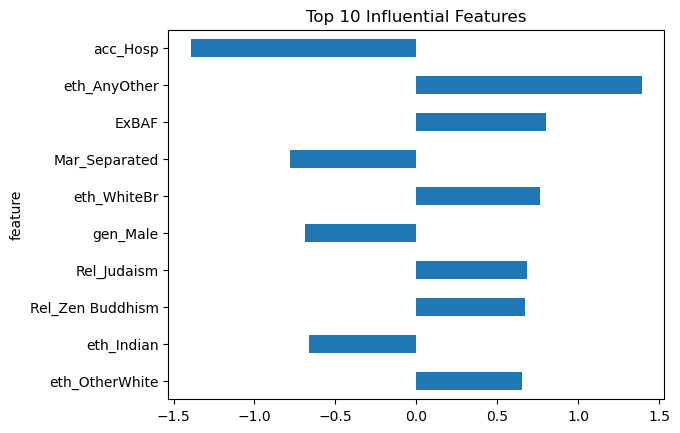

In [11]:
co_eff_df.head(10).plot(kind='barh', x='feature', y='co_eff', legend=False)
plt.title("Top 10 Influential Features")
plt.gca().invert_yaxis()
plt.show()

Use machine learning to run the data through many models

In [12]:
# 2. Run all models
results_df = ml.run_all_models(X_train, y_train, X_test, y_test)

# 3. View results
print(results_df)

c:\Users\mcdonaldh\AppData\Local\anaconda3\envs\hsma_project\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


LightGBMError: Do not support special JSON characters in feature name.

In [22]:
# Convert to DataFrame
results_df = pd.DataFrame(results_df)

#Label columns
results_df.columns = ['Model', 'Training_accuracy', 'Test_accuracy', 'Precision',
                      'Recall', 'Specificity', 'F1 Score', 'Training MAE',
                      'Testing MAE', 'Training MSE', 'Test MSE', 'Training RMSE',
                      'Test RMSE', 'Training R Squared', 'Test R Squared']

# # Save to CSV
results_df.to_csv('results_many_models.csv', index=False)

results_df

,Model,Training_accuracy,Test_accuracy,Precision,Recall,Specificity,F1 Score,Training MAE,Testing MAE,Training MSE,Test MSE,Training RMSE,Test RMSE,Training R Squared,Test R Squared
0,Decision Tree - Depth:1,0.979890,0.977431,0.977431,0.977431,0.977431,0.977431,0.020110,0.022569,0.020110,0.022569,0.141810,0.150231,-0.020523,-0.023091
1,Random Forest - Depth:1,0.979890,0.977431,0.977431,0.977431,0.977431,0.977431,0.020110,0.022569,0.020110,0.022569,0.141810,0.150231,-0.020523,-0.023091
2,XG Boost - Depth:1,0.979890,0.977431,0.977431,0.977431,0.977431,0.977431,0.020110,0.022569,0.020110,0.022569,0.141810,0.150231,-0.020523,-0.023091
3,Decision Tree - Depth:2,0.979890,0.977431,0.977431,0.977431,0.977431,0.977431,0.020110,0.022569,0.020110,0.022569,0.141810,0.150231,-0.020523,-0.023091
4,Random Forest - Depth:2,0.979890,0.977431,0.977431,0.977431,0.977431,0.977431,0.020110,0.022569,0.020110,0.022569,0.141810,0.150231,-0.020523,-0.023091
5,XG Boost - Depth:2,0.979890,0.977431,0.977431,0.977431,0.977431,0.977431,0.020110,0.022569,0.020110,0.022569,0.141810,0.150231,-0.020523,-0.023091
6,Decision Tree - Depth:3,0.979890,0.977431,0.977431,0.977431,0.977431,0.977431,0.020110,0.022569,0.020110,0.022569,0.141810,0.150231,-0.020523,-0.023091
7,Random Forest - Depth:3,0.979890,0.977431,0.977431,0.977431,0.977431,0.977431,0.020110,0.022569,0.020110,0.022569,0.141810,0.150231,-0.020523,-0.023091
8,XG Boost - Depth:3,0.979890,0.977431,0.977431,0.977431,0.977431,0.977431,0.020110,0.022569,0.020110,0.022569,0.141810,0.150231,-0.020523,-0.023091
9,Decision Tree - Depth:4,0.979890,0.977431,0.977431,0.977431,0.977431,0.977431,0.020110,0.022569,0.020110,0.022569,0.141810,0.150231,-0.020523,-0.023091


In [ ]:
# --- 1. Training vs Test Accuracy ---
x = np.arange(len(results_df["Model"]))  # model positions
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width/2, results_df["Training_accuracy"], width, label="Training", color="skyblue")
ax.bar(x + width/2, results_df["Test_accuracy"], width, label="Test", color="salmon")

ax.set_ylabel("Accuracy")
ax.set_title("Training vs Test Accuracy by Model")
ax.set_xticks(x)
ax.set_xticklabels(results_df["Model"], rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# --- 2. Precision, Recall, F1 Score ---
metrics = ["Precision", "Recall", "F1 Score"]
fig, ax = plt.subplots(figsize=(12,6))

for i, metric in enumerate(metrics):
    ax.plot(results_df["Model"], results_df[metric], marker="o", label=metric)

ax.set_ylabel("Score")
ax.set_title("Precision, Recall, and F1 Score by Model")
ax.set_xticklabels(results_df["Model"], rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

# --- 3. Error Metrics (Testing MAE, Test RMSE) ---
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width/2, results_df["Testing MAE"], width, label="Testing MAE", color="lightgreen")
ax.bar(x + width/2, results_df["Test RMSE"], width, label="Test RMSE", color="orange")

ax.set_ylabel("Error")
ax.set_title("Error Metrics by Model")
ax.set_xticks(x)
ax.set_xticklabels(results_df["Model"], rotation=90)
ax.legend()
plt.tight_layout()
plt.show()